This Jupyter Notebook creates a dataframe named "merged_df" which contains the data from "https://data.police.uk/data/" ranging from December 2010 to February 2025. The data is filtered in the following way:
- Only contains data from the Metropolitan Police
- Only has crimes in LSOAs which are in the 32 Boroughs of London (excluding City of London)

The additional dataframe named "burglar_df" uses "merged_df" but only contains the crime type of **burglary**

First, download the above specified data in the same directory as the place you saved this Notebook.This file is a template that can be used as a starting point for data manipulation and analysis.

Note: **LSOA boundaries changed slightly with Census 2021**

Note: LSOA mappings to boroughs from 2021 onwards can be found here: https://geoportal.statistics.gov.uk/datasets/0f80c523f3cd4d0fab5111572f84a2fb_0/explore?showTable=true

Note : LSOA mappings to boroughs from 2011 to before 2021 can be found here: https://geoportal.statistics.gov.uk/datasets/a5b7042782fe4ee99b8477ddf7bfe585_0/explore

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# List of boroughs in London excluding "City of London"
# LSOA names start with the name of the borough the LSOA is in
boroughs = ["Westminster", "Kensington and Chelsea", "Hammersmith and Fulham", "Wandsworth", "Lambeth", "Southwark", "Tower Hamlets", "Hackney",
            "Islington", "Camden", "Brent", "Ealing", "Hounslow", "Richmond upon Thames", "Kingston upon Thames", "Merton", "Sutton", "Croydon",
            "Bromley", "Lewisham", "Greenwich", "Bexley", "Havering", "Barking and Dagenham", "Redbridge", "Newham", "Waltham Forest", "Haringey",
            "Enfield", "Barnet", "Harrow", "Hillingdon"]

In [3]:
pop_bor = {
    'Borough': boroughs,
    'Population': [211508, 147460, 186176, 331456, 315706, 315519, 328626, 263282,
                   220584, 220903, 344521, 375340, 295706, 195513, 170454, 215219, 211123, 397741,
                   331162, 298708, 294113, 250853, 268145, 222308, 313392, 362552, 275980, 262895,
                   327429, 395007, 263448, 319018]
}
pop_df = pd.DataFrame(pop_bor)

In [4]:
# Create dictionary with month_year as key
# The value will be each corresponding csv file
from datetime import datetime, timedelta

# Start and end dates
start_date = datetime(2010, 12, 1)
end_date = datetime(2025, 2, 1)

# Dictionary to hold the variables
month_vars = {}

# Month abbreviation lookup
month_abbrs = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Generate all month keys from start to end
current = start_date
while current <= end_date:
    key = f"{month_abbrs[current.month - 1]}_{str(current.year)[-2:]}"
    month_vars[key] = None
    # Move to next month
    next_month = current.month % 12 + 1
    next_year = current.year + (current.month // 12)
    current = datetime(next_year, next_month, 1)

In [6]:
# Open the corresponding csv file for every month from start_date to end_date
start_year = int(start_date.strftime("%y"))
counter = int(start_date.strftime("%m")) - 1
for key, value in month_vars.items():
    file_name = "Data/20%02d-%02d/20%02d-%02d-metropolitan-street.csv" % (start_year + (counter // 12), (counter % 12) + 1, start_year + (counter // 12), (counter % 12) + 1)
    month_vars[key] = pd.read_csv(file_name)
    counter += 1

In [7]:
for key, value in month_vars.items():
    month_vars[key].dropna(subset = ['LSOA name'], inplace = True)

In [8]:
# Create list with names of the months (keys)
key_list = [None] * len(month_vars)
index = 0
for key, value in month_vars.items():
    key_list[index] = key
    index += 1

In [9]:
# This cell takes lots of computation power. Only has to be run once.
# For each of the month, only take rows which have LSOA name that starts with one of the boroughs in London
# Corresponding to boroughs list
b = len(boroughs)
months_x_boroughs = len(month_vars) * len(boroughs)
df_list = [None] * months_x_boroughs
for borough in range(months_x_boroughs):
    df_list[borough] = month_vars[key_list[borough // b]][month_vars[key_list[borough // b]]['LSOA name'].str.startswith(boroughs[borough % b])]

In [10]:
# Find boroughs without any crime in a given month
# Take them out of df_list if there wasn't any crime
no_crime = []
for borough in range(months_x_boroughs):
    if df_list[borough].empty:
        no_crime.append(borough)
if len(no_crime) == 0:
    sentence = 'Every borough had at least one crime in every month from %s %s to %s %s' % (start_date.strftime("%B"), start_date.strftime("%Y"), end_date.strftime("%B"), end_date.strftime("%Y"))
    print(sentence)
else:
    for i in range(len(no_crime)):
        del df_list[no_crime[i]]

Every borough had at least one crime in every month from December 2010 to February 2025


In [11]:
# Merge all dataframes in df_list into one dataframe
merged_df = pd.concat(df_list, ignore_index = True)

In [12]:
burglar_df = merged_df[merged_df['Crime type'] == 'Burglary'].reset_index(drop = True)

In [13]:
ranking = burglar_df['LSOA name'].value_counts().reset_index()
ranking.columns = ['LSOA name', 'Burglaries']

In [14]:
# Total burglaries per borough
per_bor = ranking.copy()
per_bor['LSOA name'] = per_bor['LSOA name'].str.split(' ').str[0]
bor_totals = per_bor.groupby('LSOA name')['Burglaries'].sum().reset_index()
bor_totals.sort_values(by = 'Burglaries', ascending = False, inplace = True)
bor_totals = bor_totals[bor_totals['LSOA name'] != 'Brentwood']
bor_totals.reset_index()
bor_totals.rename(columns = {'LSOA name': 'Borough'}, inplace = True)
bor_totals.head()

,Borough,Burglaries
1,Barnet,48679
32,Westminster,48213
27,Southwark,41169
21,Lambeth,40909
7,Croydon,40326


In [15]:
# Burglaries per 1000 inhabitants
pop_df_2 = pop_df.copy()
pop_df_2['Borough'] = pop_df_2['Borough'].str.split(' ').str[0]
pop_burg = pd.merge(pop_df_2, bor_totals, on = 'Borough')
pop_burg['Burglaries per 1000'] = pop_burg['Burglaries'] / (pop_burg['Population'] / 1000)
pop_burg.sort_values(by = 'Burglaries per 1000', ascending = False, inplace = True)

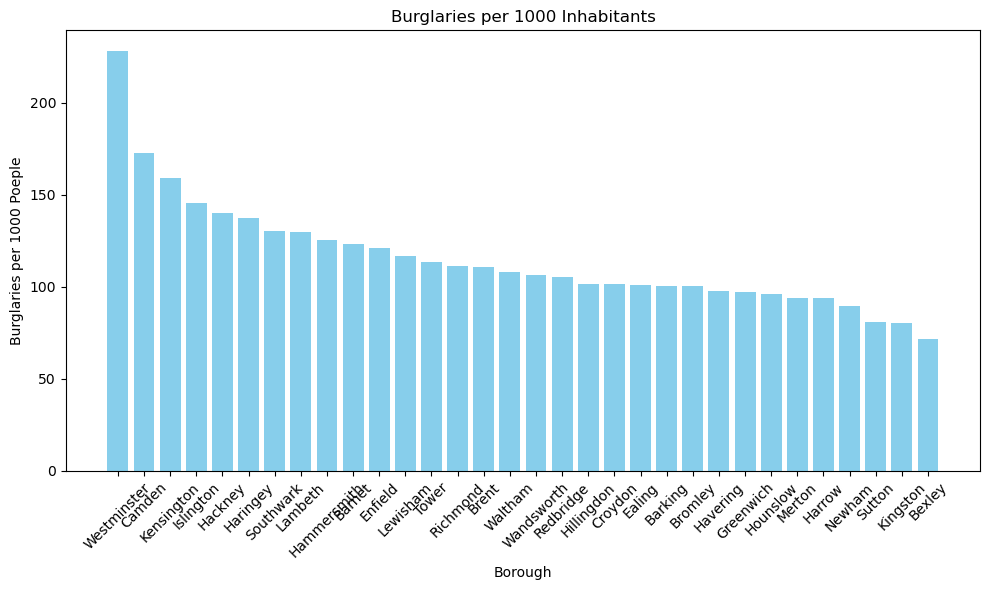

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(pop_burg['Borough'], pop_burg['Burglaries per 1000'], color='skyblue')
plt.title('Burglaries per 1000 Inhabitants')
plt.xlabel('Borough')
plt.ylabel('Burglaries per 1000 Poeple')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

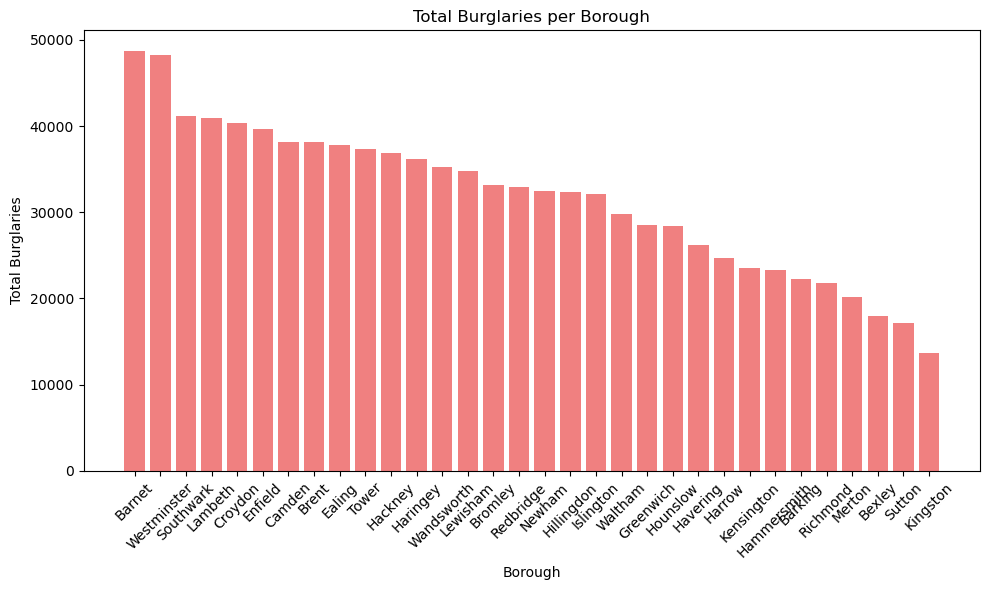

In [17]:
bor_totals.sort_values(by = 'Burglaries', ascending = False, inplace = True)
plt.figure(figsize=(10, 6))
plt.bar(bor_totals['Borough'], bor_totals['Burglaries'], color='lightcoral')
plt.title('Total Burglaries per Borough')
plt.xlabel('Borough')
plt.ylabel('Total Burglaries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

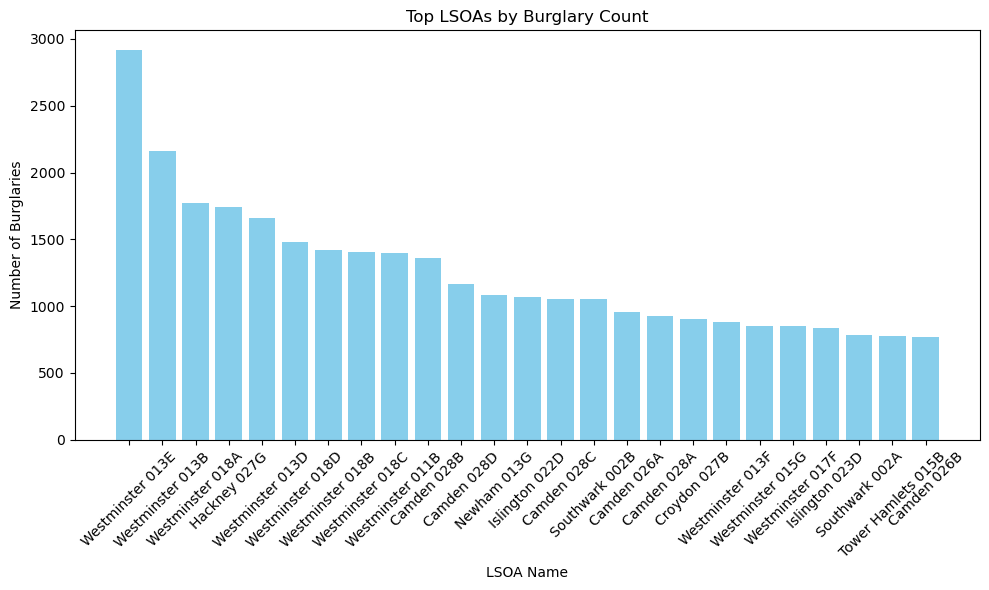

In [18]:
# Top LSOA Burglary Count Bar Chart
top_n = 25
top_LSOA = ranking.head(top_n)

plt.figure(figsize=(10, 6))
plt.bar(top_LSOA['LSOA name'], top_LSOA['Burglaries'], color='skyblue')
plt.title('Top LSOAs by Burglary Count')
plt.xlabel('LSOA Name')
plt.ylabel('Number of Burglaries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
burglar_df = burglar_df[['Month', 'Longitude', 'Latitude', 'LSOA code', 'LSOA name']]
burglar_df_bor = burglar_df.copy()
burglar_df_bor['LSOA name'] = burglar_df_bor['LSOA name'].str.split(' ').str[0]
burglar_df_bor.rename(columns = {'LSOA name': 'Borough'}, inplace = True)
burglar_month = burglar_df_bor.groupby(['Month', 'Borough']).size().reset_index(name = 'Burglaries')

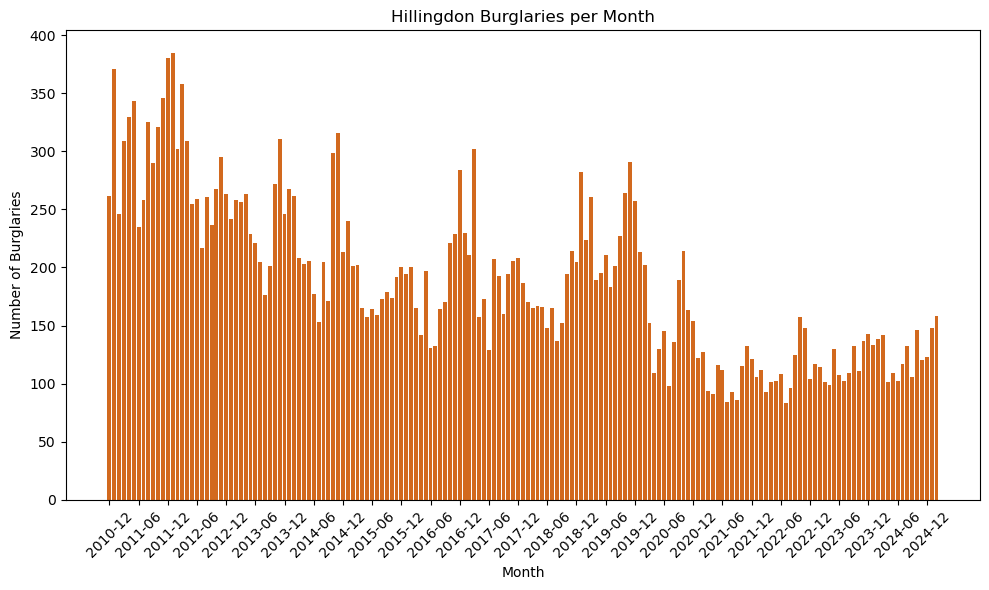

In [20]:
# Local minima are at months 06 through 09, mostly at 06 and 07
# Local maxima are at the months 11 through 02
# These show seasonal changes in burglaries. Less during summer and more during winter

hillingdon_burg = burglar_month[burglar_month['Borough'] == 'Hillingdon']

fig_hill, ax_hill = plt.subplots(figsize=(10, 6))
ax_hill.bar(hillingdon_burg['Month'], hillingdon_burg['Burglaries'], color='chocolate')
ax_hill.set_xticks(ax_hill.get_xticks()[::6])
plt.title('Hillingdon Burglaries per Month')
plt.xlabel('Month')
plt.ylabel('Number of Burglaries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

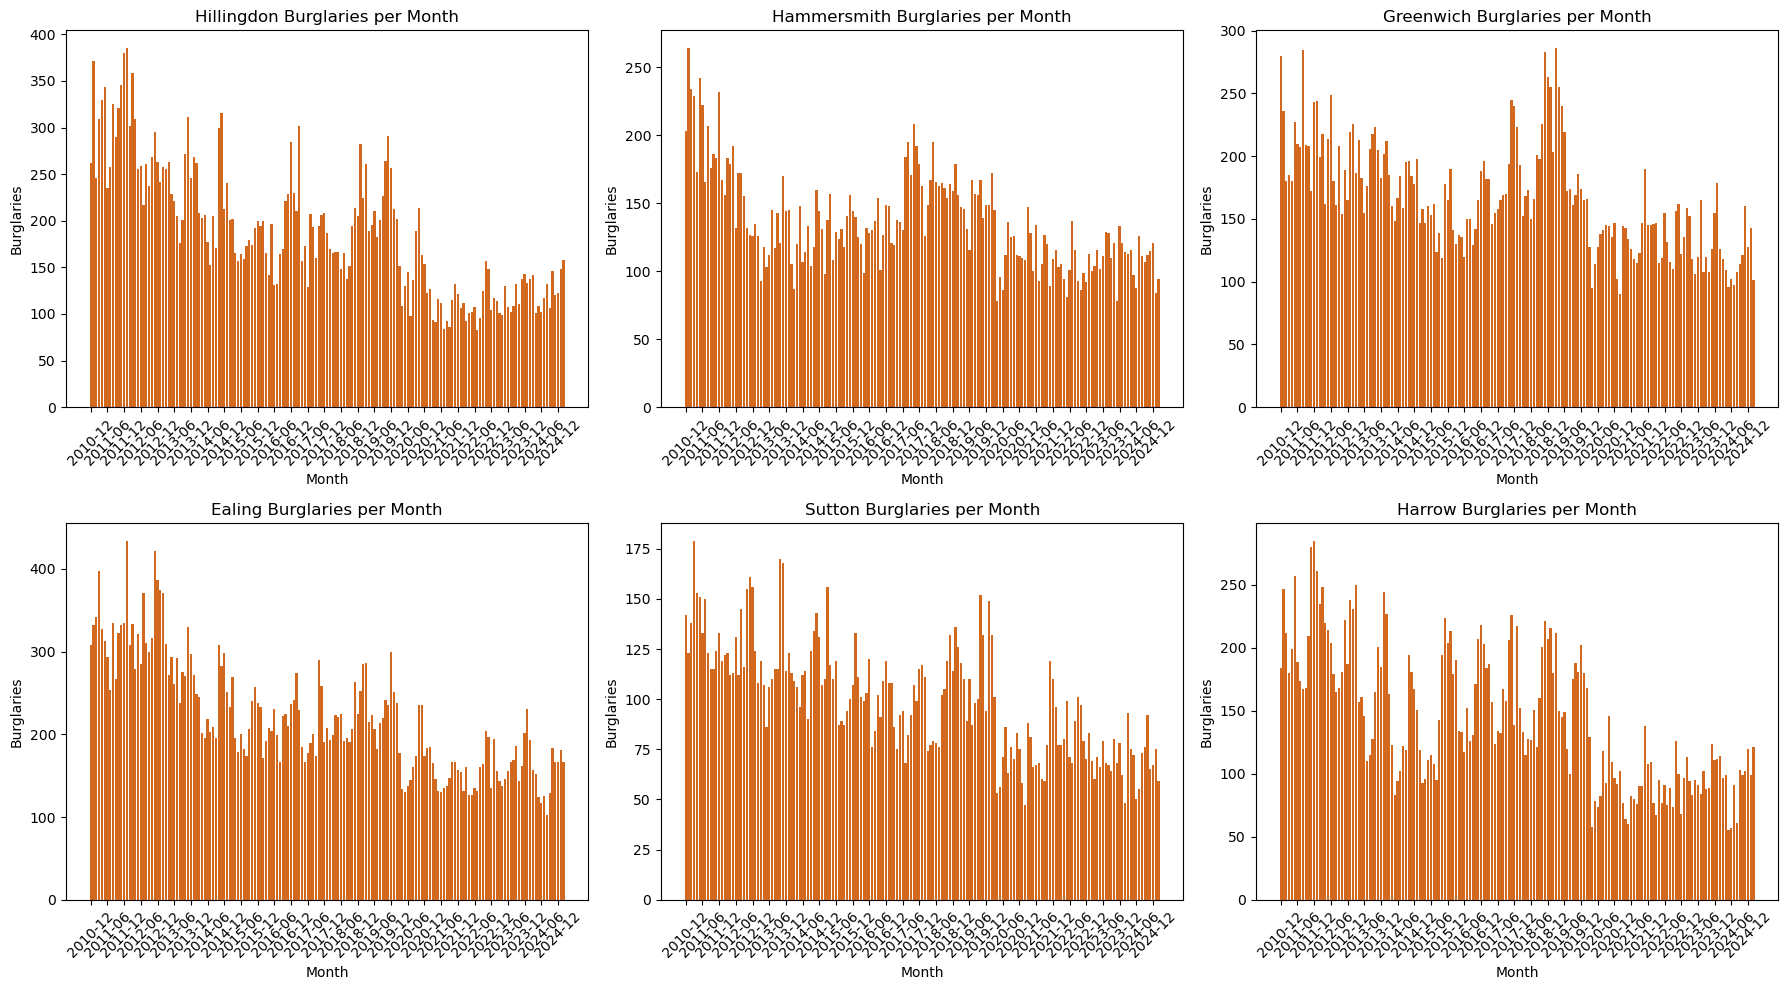

In [21]:
# List of 6 boroughs with most CCTV Cameras per 10,000 people 2023
# CCTV cameras listed in public spaces
# Source: https://londonist.com/london/features/cctv-cameras-how-many-london-boroughs
boroughs_cctv = ['Hillingdon', 'Hammersmith', 'Greenwich', 'Ealing', 'Sutton', 'Harrow']

# Set up grid of subplots: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Flatten to 1D for easy iteration

for i, borough in enumerate(boroughs_cctv):
    ax = axes[i]

    # Filter data for the borough
    borough_data = burglar_month[burglar_month['Borough'] == borough]

    # Plot bar chart
    ax.bar(borough_data['Month'], borough_data['Burglaries'], color='chocolate')
    ax.set_title(f'{borough} Burglaries per Month')
    ax.set_xticks(ax.get_xticks()[::6])  # Adjust for readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Month')
    ax.set_ylabel('Burglaries')

# Hide any unused subplots (if boroughs < total grid slots)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

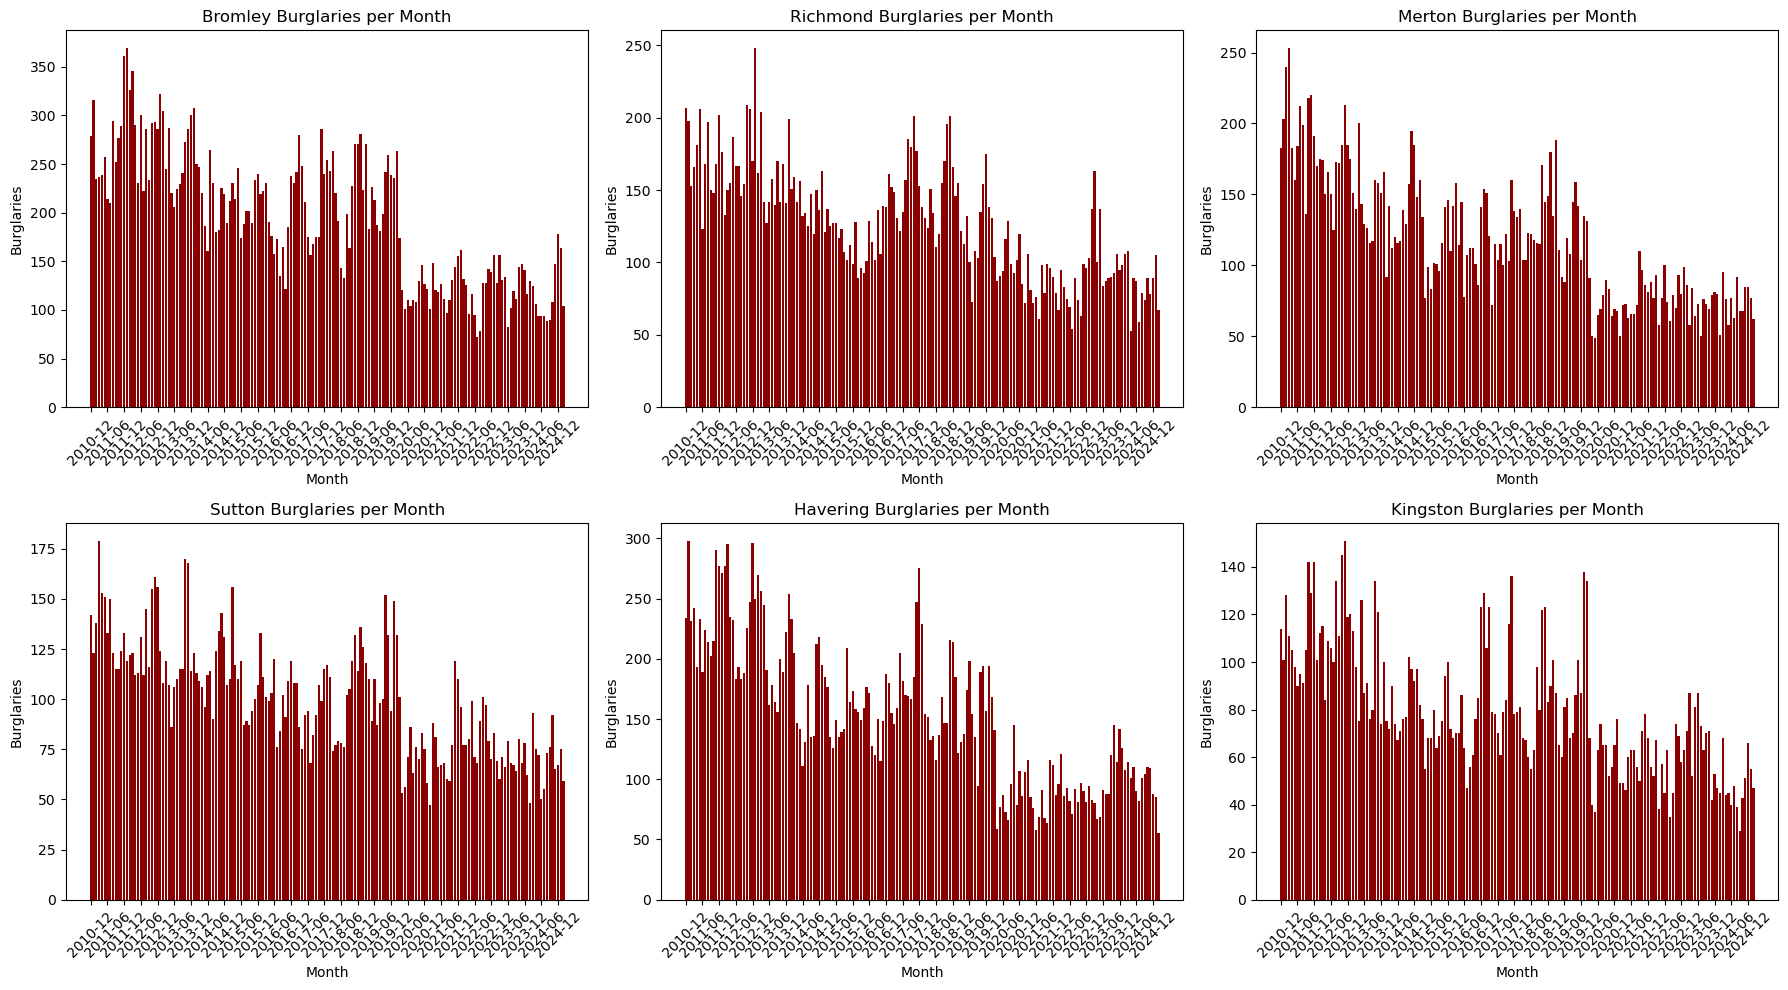

In [22]:
# Boroughs with the most LSOAs in the bottom 50 IMD scores
# Bromley: 13, Richmond: 9, Merton: 5, Sutton: 5, Havering: 4, Kingston: 4
boroughs_low_imd = ['Bromley', 'Richmond', 'Merton', 'Sutton', 'Havering', 'Kingston']

# Set up grid of subplots: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()  # Flatten to 1D for easy iteration

for i, borough in enumerate(boroughs_low_imd):
    ax = axes[i]

    # Filter data for the borough
    borough_data = burglar_month[burglar_month['Borough'] == borough]

    # Plot bar chart
    ax.bar(borough_data['Month'], borough_data['Burglaries'], color='darkred')
    ax.set_title(f'{borough} Burglaries per Month')
    ax.set_xticks(ax.get_xticks()[::6])  # Adjust for readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('Month')
    ax.set_ylabel('Burglaries')

# Hide any unused subplots (if boroughs < total grid slots)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [24]:
burglar_df.to_csv('Burglars.csv', index=False)